<a href="https://colab.research.google.com/github/fujitako03/EffectivenessVerificationIntroduction/blob/main/%E5%8A%B9%E6%9E%9C%E6%A4%9C%E8%A8%BC%E5%85%A5%E9%96%80_1%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 効果検証入門 第1章
このNotebookは[『効果検証入門』](https://amzn.asia/d/eVbiihS)に掲載されているRプログラムをPythonで書き直したものです。

非公式に作成されたものであり、書籍の内容と整合性が合うことを保証していません。

In [31]:
import pandas as pd
import numpy as np
import japanize_matplotlib

japanize_matplotlib.japanize()


## Load Data
メールマーケティングのデータセットである[MineThatData E-Mail Analytics And Data Mining Challenge dataset](https://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html)を利用。

In [2]:
df_raw = pd.read_csv("http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
print(df_raw.shape)
df_raw.head()

(64000, 12)


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


## Preprocess
不要なデータを除去する

In [3]:
# 女性向けメールを除く
df_male = df_raw.query("segment != 'Womens E-Mail'")
print(df_male.shape)
print(df_male.segment.value_counts())

(42613, 12)
Mens E-Mail    21307
No E-Mail      21306
Name: segment, dtype: int64


In [4]:
# 介入を表すtreatment変数を追加
df_male.loc[:, "treatment"] = np.where(df_male["segment"].copy() == 'Mens E-Mail', 1, 0)

<ipython-input-4-3bf00953045d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_male.loc[:, "treatment"] = np.where(df_male["segment"].copy() == 'Mens E-Mail', 1, 0)


## 集計
介入群と非介入群で購買率と平均購入金額の差を調べる。
### 結果
- 購買率
  - 介入群：1.25%
  - 非介入群：0.57%
- 平均購入金額
  - 介入群：1.42
  - 非介入群：0.65

In [5]:
_group = df_male.groupby("treatment").agg(
    {"conversion": "mean",
     "spend": "mean",
     "channel": "count"}
    ).rename(columns={"conversion": "conversion_mean" ,"spend": "spend_mean", "channel": "count"})
_group

,conversion_mean,spend_mean,count
treatment,,,
0,0.005726,0.652789,21306
1,0.012531,1.422617,21307


In [28]:
# 可視化用関数
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
japanize_matplotlib.japanize()


plt.style.use('seaborn-v0_8-whitegrid')

def plot_bar_graph(x_categories, y_values, hue_categories, hue_colors, xlabel, ylabel, title, percent=False):
    """
    fivethirtyeightスタイルでhue_categoriesについてのみ凡例を表示する棒グラフを描く関数
    """

    # グラフの描画設定
    plt.figure(figsize=(8,6))# グラフサイズ
    bar_width = 0.35 # 棒の幅
    num_x_categories = len(x_categories) # X軸のカテゴリ数
    x = range(num_x_categories) # X軸のindex（ラベル位置調整に利用）

    # 凡例用のラベルを追加するためのフラグ
    added_legend = [False, False]

    # カテゴリ×サブカテごとに要素を追加
    for i, (x_category, y_value_set) in enumerate(zip(x_categories, y_values)):
        for j, (hue_category, hue_color, y_value) in enumerate(zip(hue_categories, hue_colors, y_value_set)):
            # 凡例ラベルを設定（初めて出現した場合のみ）
            legend_label = hue_category if not added_legend[j] else ""

            # 棒グラフを描画
            plt.bar(i + j * bar_width, y_value, color=hue_color, width=bar_width, label=legend_label)

            # 値ラベルを棒の上に表示
            y_value_str = f"{y_value:.1%}" if percent else str(y_value)
            plt.text(i + j * bar_width, y_value, y_value_str, ha='center', va='bottom')

            # 凡例ラベルを追加した場合、フラグを更新
            if legend_label:
                added_legend[j] = True


    # グラフを描画
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.xticks([i + bar_width / 2 for i in x], x_categories) # X軸のラベル位置を調整
    if percent:
      plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    plt.show()



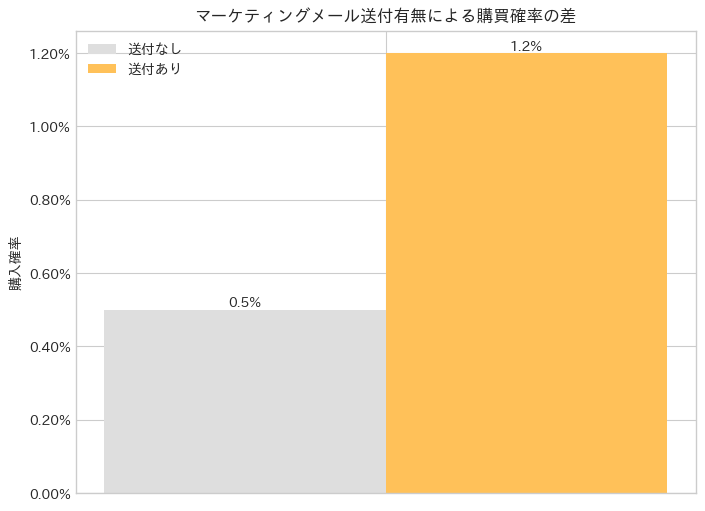

In [32]:
# サンプルデータとパラメータで関数をテスト
x_categories = ['']
y_values = [[0.005, 0.012]]
hue_categories = ['送付なし', '送付あり']
hue_colors = ['#DEDEDE', '#FFC159'] # #E85DA7, #5981FF
xlabel = ''
ylabel = '購入確率'
title = 'マーケティングメール送付有無による購買確率の差'
percent=True
plot_bar_graph(x_categories, y_values, hue_categories, hue_colors, xlabel, ylabel, title, percent)

## 有意差検定


In [38]:
from scipy import stats

treat = df_male.query("treatment == 1")["conversion"]
no_treat = df_male.query("treatment == 0")["conversion"]
print(f"means treat: {np.mean(treat)} no_treat: {np.mean(no_treat)}")
print(f"vars  treat: {np.var(treat)} no_treat: {np.var(no_treat)}")

# 検定
t_value, p_value = stats.ttest_ind(a=treat, b=no_treat, equal_var=True)
print("t_value:", t_value)
print("p_value:", p_value)

# 結果
if p_value < 0.025:
    print(f"p = {p_value:.3f} のため、帰無仮説が棄却されました。AとBに差があります")
else:
    print(f"{p_value:.3f} のため、帰無仮説が採択されました。AとBに差があるとは言えません")

means treat: 0.01253109306800582 no_treat: 0.005726086548390125
vars  treat: 0.012374064774526801 no_treat: 0.0056932984812304716
t_value: 7.389671596517989
p_value: 1.4988265260257047e-13
p = 0.000 のため、帰無仮説が棄却されました。AとBに差があります
